1. Load libraries and EPlus outputs collection

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import importlib, inspect
from joblib import Parallel, delayed
import time

# Caminho para a raiz do projeto (onde está a pasta src)
ROOT = Path().resolve().parent  # se o notebook estiver dentro de uma subpasta, use .parent ou .parents[1]
sys.path.append(str(ROOT))

import src.io_eplus as io_eplus
importlib.reload(io_eplus)  
from src.io_eplus import load_eplus_folder
from src.jos3_runner import run_jos3_hourly

In [2]:
SITE_ID = "MAO"
EPLUS_DIR = Path("../data/eplus") / SITE_ID
PROC_DIR  = Path("../data/processed") / SITE_ID
INTERIM_DIR = Path("../data/interim") / SITE_ID


In [3]:
# Meteorologia + flags (passo 1)
met = pd.read_csv(
    PROC_DIR / "full_timeseries_with_flags_and_metrics.csv.gz",
    parse_dates=["timeset"],
    low_memory=False
)

In [4]:
# EnergyPlus (apenas VN)
vn = load_eplus_folder(
    EPLUS_DIR,
    site_id=SITE_ID,
    system_filter="vn",
    case_filter=["Caso1", "Caso2", "Caso3"],
    wide=True
)

Lendo U001_Caso1_1a7_vn_821110_MY.1991.csv (ano 1991, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1992.csv (ano 1992, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1993.csv (ano 1993, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1994.csv (ano 1994, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1995.csv (ano 1995, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1996.csv (ano 1996, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1997.csv (ano 1997, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1998.csv (ano 1998, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.1999.csv (ano 1999, unit=U001, case=Caso1, system=vn, seed=821110)...
Lendo U001_Caso1_1a7_vn_821110_MY.2000.csv (ano 2000, unit=U001,

In [5]:
print("=== QC EnergyPlus (VN) ===")

# colunas de interesse (wide)
cols_temp = [c for c in vn.columns if c.endswith("Tair_C") or c.endswith("Top_C")]
cols_rh   = [c for c in vn.columns if c.endswith("RH_pct")]
cols_hi   = [c for c in vn.columns if c.endswith("HeatIndex_C")]

def describe_cols(df, cols):
    if not cols:
        return pd.DataFrame()
    desc = df[cols].describe().T[["mean","std","min","50%","max"]]
    return desc.round(2)

# agrupar por scenario (CasoX_vn)
group_keys = ["scenario"]
# se você tiver múltiplas unidades / seeds no mesmo DF, use isto:
# group_keys = ["unit_id", "scenario", "seed"]

for g, dfg in vn.groupby(group_keys, dropna=False):
    # g pode ser string (scenario) ou tupla (se usar múltiplas chaves)
    label = g if isinstance(g, str) else " | ".join(map(str, g))

    print("\n" + "="*80)
    print(f"SCENARIO: {label}")
    print("="*80)

    # Estrutura geral
    print(f"Total de registros: {len(dfg):,}")
    print("Período:",
          dfg["timeset"].min().strftime("%Y-%m-%d %H:%M"),
          "→",
          dfg["timeset"].max().strftime("%Y-%m-%d %H:%M"))

    print("Colunas:", list(dfg.columns[:10]), "...")

    # Estatísticas
    print("\n--- Temperaturas (°C) ---")
    print(describe_cols(dfg, cols_temp))

    print("\n--- Umidade Relativa (%) ---")
    print(describe_cols(dfg, cols_rh))

    if cols_hi:
        print("\n--- Heat Index (°C) ---")
        print(describe_cols(dfg, cols_hi))

    # Checagem de NaNs
    for c in cols_temp + cols_rh:
        n = dfg[c].isna().sum()
        if n > 0:
            print(f"[WARN] {c}: {n} NaN encontrados")

    # Zonas detectadas (wide)
    meta_prefixes = {"site", "unit", "case", "system", "scenario", "seed", "time", "year", "month", "day", "hour"}
    zones = sorted({
        c.split("_")[0]
        for c in dfg.columns
        if "_" in c and c.split("_")[0].lower() not in meta_prefixes
    })
    print("\nZonas detectadas:", ", ".join(zones))


=== QC EnergyPlus (VN) ===

SCENARIO: Caso1_vn
Total de registros: 289,080
Período: 1991-01-01 01:00 → 2024-01-01 00:00
Colunas: ['timeset', 'site_id', 'unit_id', 'case', 'system', 'scenario', 'seed', 'year', 'month', 'day'] ...

--- Temperaturas (°C) ---
               mean   std    min    50%    max
SALA_Tair_C   29.67  2.42  21.33  29.21  39.46
SALA_Top_C    30.52  2.35  22.87  30.16  40.03
DORM1_Tair_C  29.74  2.39  20.91  29.29  39.15
DORM1_Top_C   30.45  2.26  22.64  30.15  39.14
DORM2_Tair_C  29.50  2.36  21.98  29.09  38.70
DORM2_Top_C   30.36  2.28  23.34  30.06  38.74
BWC_Tair_C    30.28  2.45  23.33  29.85  39.88
BWC_Top_C     30.80  2.44  23.72  30.43  39.84

--- Umidade Relativa (%) ---
               mean   std    min    50%     max
SALA_RH_pct   71.49  9.44  23.26  73.17   97.85
DORM1_RH_pct  71.46  9.33  24.77  73.06   99.16
DORM2_RH_pct  72.22  9.44  23.84  73.70   99.27
BWC_RH_pct    68.39  9.46  22.75  69.88  100.00

--- Heat Index (°C) ---
                    mean  

In [6]:
# salva em Parquet (recomendado) e também CSV se quiser inspecionar
out_parquet = INTERIM_DIR / f"eplus_vn.parquet"
out_csv     = INTERIM_DIR / f"eplus_vn.csv.gz"

In [7]:
vn.to_parquet(out_parquet, index=False)
vn.to_csv(out_csv, index=False, compression="gzip")


In [8]:
# EnergyPlus (apenas AC)
ac = load_eplus_folder(
    EPLUS_DIR,
    site_id=SITE_ID,
    system_filter="ac",
    case_filter=["Caso1", "Caso2", "Caso3"],
    wide=True
)

Lendo U001_Caso1_1a7_ac_821110_MY.1991.csv (ano 1991, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1992.csv (ano 1992, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1993.csv (ano 1993, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1994.csv (ano 1994, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1995.csv (ano 1995, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1996.csv (ano 1996, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1997.csv (ano 1997, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1998.csv (ano 1998, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.1999.csv (ano 1999, unit=U001, case=Caso1, system=ac, seed=821110)...
Lendo U001_Caso1_1a7_ac_821110_MY.2000.csv (ano 2000, unit=U001,

In [9]:
print("=== QC EnergyPlus (AC) ===")

# Seleções (wide)
cols_e_heat = [c for c in ac.columns if c.endswith("_Heat_E_kWh")]
cols_e_cool = [c for c in ac.columns if c.endswith("_Cool_E_kWh")]
cols_p_heat = [c for c in ac.columns if c.endswith("_Heat_P_W")]
cols_p_cool = [c for c in ac.columns if c.endswith("_Cool_P_W")]

def describe_cols(df, cols):
    if not cols:
        return "(nenhuma coluna)"
    return df[cols].describe().T[["mean","std","min","50%","max"]].round(2)

def energy_totals_kwh(df, cols, label):
    if not cols:
        print(f"(nenhuma coluna de {label})")
        return
    tot = df[cols].sum().sort_values(ascending=False).round(2)
    print(f"\n--- Energia total {label} (kWh) no período ---")
    print(tot.to_string())

def zones_from(cols):
    return sorted({c.split("_", 1)[0] for c in cols})

# Agrupamento recomendado
group_keys = ["scenario"]
# se tiver múltiplos unit_id/seed no mesmo DF, use:
# group_keys = ["unit_id", "scenario", "seed"]

for g, dfg in ac.groupby(group_keys, dropna=False):
    label = g if isinstance(g, str) else " | ".join(map(str, g))

    print("\n" + "="*80)
    print(f"SCENARIO: {label}")
    print("="*80)

    print(f"Registros: {len(dfg):,}")
    print("Período:",
          dfg["timeset"].min().strftime("%Y-%m-%d %H:%M"),
          "→",
          dfg["timeset"].max().strftime("%Y-%m-%d %H:%M"))
    print("Colunas:", list(dfg.columns[:10]), "...")

    # Potência (W)
    print("\n--- Potência aquecimento (W) ---")
    print(describe_cols(dfg, cols_p_heat))

    print("\n--- Potência resfriamento (W) ---")
    print(describe_cols(dfg, cols_p_cool))

    # Energia (kWh) – totais no período (por cenário!)
    energy_totals_kwh(dfg, cols_e_heat, "aquecimento")
    energy_totals_kwh(dfg, cols_e_cool, "resfriamento")

    # NaNs
    for c in cols_e_heat + cols_e_cool + cols_p_heat + cols_p_cool:
        n = int(dfg[c].isna().sum())
        if n:
            print(f"[WARN] {c}: {n} NaN")

    # Zonas detectadas
    zones = sorted(set(zones_from(cols_e_heat + cols_e_cool + cols_p_heat + cols_p_cool)))
    print("\nZonas (AC):", ", ".join(zones) if zones else "(nenhuma)")


=== QC EnergyPlus (AC) ===

SCENARIO: Caso1_ac
Registros: 289,080
Período: 1991-01-01 01:00 → 2024-01-01 00:00
Colunas: ['timeset', 'site_id', 'unit_id', 'case', 'system', 'scenario', 'seed', 'year', 'month', 'day'] ...

--- Potência aquecimento (W) ---
                mean  std  min  50%  max
DORM1_Heat_P_W   0.0  0.0  0.0  0.0  0.0
DORM2_Heat_P_W   0.0  0.0  0.0  0.0  0.0
SALA_Heat_P_W    0.0  0.0  0.0  0.0  0.0

--- Potência resfriamento (W) ---
                   mean     std     min      50%      max
DORM1_Cool_P_W   574.92  208.37  142.07   540.32  1340.86
DORM2_Cool_P_W   583.90  223.05  126.86   543.65  1324.66
SALA_Cool_P_W   1503.23  548.67  372.53  1389.13  3809.78

--- Energia total aquecimento (kWh) no período ---
DORM1_Heat_E_kWh    0.0
DORM2_Heat_E_kWh    0.0
SALA_Heat_E_kWh     0.0

--- Energia total resfriamento (kWh) no período ---
SALA_Cool_E_kWh     434553.06
DORM2_Cool_E_kWh    168794.85
DORM1_Cool_E_kWh    166197.75

Zonas (AC): DORM1, DORM2, SALA

SCENARIO: Caso2

In [10]:
# salva em Parquet (recomendado) e também CSV se quiser inspecionar
out_parquet = INTERIM_DIR / f"eplus_ac.parquet"
out_csv     = INTERIM_DIR / f"eplus_ac.csv.gz"

In [11]:
ac.to_parquet(out_parquet, index=False)
ac.to_csv(out_csv, index=False, compression="gzip")


2. JOS3 

In [12]:
def build_env_inputs(vn_df: pd.DataFrame, zone: str, default_vel=0.1) -> pd.DataFrame:
    cols_meta = [c for c in ["site_id","unit_id","case","system","scenario","seed"] if c in vn_df.columns]

    out = vn_df[["timeset"] + cols_meta].copy()

    out["ta"] = vn_df[f"{zone}_Tair_C"]

    rh_col = f"{zone}_RH_pct"
    out["rh"] = vn_df[rh_col] if rh_col in vn_df.columns else np.nan

    tr_col = f"{zone}_MRT_C"
    if tr_col in vn_df.columns:
        out["tr"] = vn_df[tr_col]
    else:
        top_col = f"{zone}_Top_C"
        if top_col in vn_df.columns:
            out["tr"] = 2 * vn_df[top_col] - vn_df[f"{zone}_Tair_C"]
        else:
            out["tr"] = out["ta"]

    out["vel"] = default_vel
    return out


In [13]:
def run_and_suffix(env: pd.DataFrame, age: int, suffix: str) -> pd.DataFrame:
    out = run_jos3_hourly(
        env=env,
        col_ta="ta",
        col_to="tr",   
        col_rh="rh",
        ts_col="timeset",
        dt_seconds=600,
        model_kwargs=dict(
            height=1.7, weight=60, fat=25, age=age, sex="male",
            bmr_equation="harris-benedict", bsa_equation="dubois",
            clo=0.5,
        ),
    ).copy()

    rename = {c: f"{c}_{suffix}" for c in out.columns if c != "timeset"}
    return out.rename(columns=rename)

In [14]:
def run_one_scenario(
    dfg: pd.DataFrame,
    scenario: str,
    zone: str,
    met_cols_df: pd.DataFrame,   
    proc_dir: Path,
    test_year: int | None = None,
) -> str:
    label = scenario if test_year is None else f"{scenario}_{test_year}"

    # ordenar + garantir unicidade
    dfg = dfg.sort_values("timeset")
    if not dfg["timeset"].is_unique:
        raise ValueError(f"timeset duplicado em scenario={scenario}")

    # construir inputs ambientais + anexar flags outdoor
    env = build_env_inputs(dfg, zone, default_vel=0.1)
    env = env.merge(met_cols_df, on="timeset", how="left")

    # rodar JOS3 para duas idades
    jos3_30 = run_and_suffix(env, age=30, suffix="age30")
    jos3_75 = run_and_suffix(env, age=75, suffix="age75")
    jos3_out = jos3_30.merge(jos3_75, on="timeset", how="inner")

    # anexar metadados (se existirem no dfg)
    meta_present = [c for c in META_COLS if c in dfg.columns]
    if meta_present:
        meta_vals = dfg.iloc[0][meta_present].to_dict()
        for k, v in meta_vals.items():
            jos3_out[k] = v

    # salvar
    out_path = proc_dir / f"jos3_output_{zone}_{label}.csv.gz"
    jos3_out.to_csv(out_path, index=False, compression="gzip")
    return str(out_path)

In [15]:
met_aligned = met[~((met["timeset"].dt.month == 2) & (met["timeset"].dt.day == 29))].copy()

# (recomendado) ordenar e checar duplicatas
met_aligned = met_aligned.sort_values("timeset").reset_index(drop=True)
if not met_aligned["timeset"].is_unique:
    dup = met_aligned["timeset"].duplicated().sum()
    raise ValueError(f"met_aligned tem {dup} timeset duplicados (merge com VN vai replicar linhas).")

# salva em Parquet (recomendado) e também CSV se quiser inspecionar
out_parquet = INTERIM_DIR / "met_aligned.parquet"
out_csv     = INTERIM_DIR / "met_aligned.csv.gz"

met_aligned.to_parquet(out_parquet, index=False)
met_aligned.to_csv(out_csv, index=False, compression="gzip")

print("✅ met_aligned salvo em:")
print("-", out_parquet)
print("-", out_csv)

✅ met_aligned salvo em:
- ..\data\interim\MAO\met_aligned.parquet
- ..\data\interim\MAO\met_aligned.csv.gz


In [16]:
ZONE = "DORM1"

vn_only = vn[vn["system"] == "vn"].copy()


In [17]:
print("VN range:", vn_only["timeset"].min(), "→", vn_only["timeset"].max())
print("MET range:", met_aligned["timeset"].min(), "→", met_aligned["timeset"].max())

VN range: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
MET range: 1991-01-01 01:00:00 → 2024-01-01 00:00:00


In [18]:
META_COLS = ["site_id", "unit_id", "case", "system", "scenario", "seed"]
MET_COLS = ["timeset", "HW_INMET_bool", "HW_OU_bool", "INMET_hw_id", "OUZ_hw_id"]

In [19]:
#start = pd.Timestamp("1991-01-01 00:00:00")
#end   = pd.Timestamp("1991-12-31 00:00:00")  

#vn_week = vn[(vn["system"] == "vn") & (vn["timeset"] >= start) & (vn["timeset"] < end)].copy()
#met_week = met_aligned[(met_aligned["timeset"] >= start) & (met_aligned["timeset"] < end)].copy()

#print("VN week rows:", len(vn_week), " | scenarios:", vn_week["scenario"].unique())
#print("MET week rows:", len(met_week))

In [20]:
met_cols_df = met_aligned[MET_COLS].copy()

def main():
    ZONE = "DORM1"

    jobs = [(scenario, dfg) for scenario, dfg in vn_only.groupby("scenario")]

    paths = Parallel(n_jobs=3, verbose=10)(
        delayed(run_one_scenario)(dfg, scenario, ZONE, met_cols_df, PROC_DIR)
        for scenario, dfg in jobs
    )

    print("Arquivos gerados:")
    for p in paths:
        print("-", p)

if __name__ == "__main__":
    main()

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 166.7min finished


Arquivos gerados:
- ..\data\processed\MAO\jos3_output_DORM1_Caso1_vn.csv.gz
- ..\data\processed\MAO\jos3_output_DORM1_Caso2_vn.csv.gz
- ..\data\processed\MAO\jos3_output_DORM1_Caso3_vn.csv.gz


In [32]:
ZONE = "DORM1"

In [33]:
# pega os arquivos (ajuste o padrão se necessário)
files = sorted(PROC_DIR.glob(f"jos3_output_{ZONE}_Caso*_vn*.csv.gz"))
print("Arquivos encontrados:")
for f in files:
    print("-", f.name)

Arquivos encontrados:
- jos3_output_DORM1_Caso1_vn.csv.gz
- jos3_output_DORM1_Caso2_vn.csv.gz
- jos3_output_DORM1_Caso3_vn.csv.gz


In [34]:
dfs = []
for f in files:
    df = pd.read_csv(f, compression="gzip")
    df["timeset"] = pd.to_datetime(df["timeset"])
    # garante scenario (se já existe no arquivo, ok; senão extrai do nome)
    if "scenario" not in df.columns:
        # exemplo: jos3_output_DORM1_Caso1_vn_1991.csv.gz -> Caso1_vn
        scenario = f.name.split(f"jos3_output_{ZONE}_", 1)[1].split(".csv.gz")[0]
        df["scenario"] = scenario
    dfs.append(df)

jos3_all = pd.concat(dfs, ignore_index=True)
jos3_all = jos3_all.sort_values(["scenario", "timeset"]).reset_index(drop=True)

print("\nColunas disponíveis no JOS3:")
print(jos3_all.columns.tolist())
print("\nAmostra:")
print(jos3_all.head(3))


Colunas disponíveis no JOS3:
['timeset', 't_skin_mean_age30', 't_core_age30', 'w_mean_age30', 't_skin_mean_age75', 't_core_age75', 'w_mean_age75', 'site_id', 'unit_id', 'case', 'system', 'scenario', 'seed']

Amostra:
              timeset  t_skin_mean_age30  t_core_age30  w_mean_age30  \
0 1991-01-01 01:00:00              35.23         36.78          0.20   
1 1991-01-01 02:00:00              35.21         36.79          0.20   
2 1991-01-01 03:00:00              35.18         36.78          0.19   

   t_skin_mean_age75  t_core_age75  w_mean_age75 site_id unit_id   case  \
0              35.25         37.14          0.13     MAO    U001  Caso1   
1              35.23         37.14          0.13     MAO    U001  Caso1   
2              35.20         37.14          0.12     MAO    U001  Caso1   

  system  scenario    seed  
0     vn  Caso1_vn  821110  
1     vn  Caso1_vn  821110  
2     vn  Caso1_vn  821110  


In [24]:
jos3_all.head()

,timeset,t_skin_mean_age30,t_core_age30,w_mean_age30,t_skin_mean_age75,t_core_age75,w_mean_age75,site_id,unit_id,case,system,scenario,seed
0,1991-01-01 01:00:00,35.23,36.78,0.20,35.25,37.14,0.13,MAO,U001,Caso1,vn,Caso1_vn,821110
1,1991-01-01 02:00:00,35.21,36.79,0.20,35.23,37.14,0.13,MAO,U001,Caso1,vn,Caso1_vn,821110
2,1991-01-01 03:00:00,35.18,36.78,0.19,35.20,37.14,0.12,MAO,U001,Caso1,vn,Caso1_vn,821110
3,1991-01-01 04:00:00,35.16,36.78,0.17,35.17,37.13,0.11,MAO,U001,Caso1,vn,Caso1_vn,821110
4,1991-01-01 05:00:00,35.14,36.78,0.17,35.14,37.13,0.11,MAO,U001,Caso1,vn,Caso1_vn,821110


In [25]:
import matplotlib.pyplot as plt

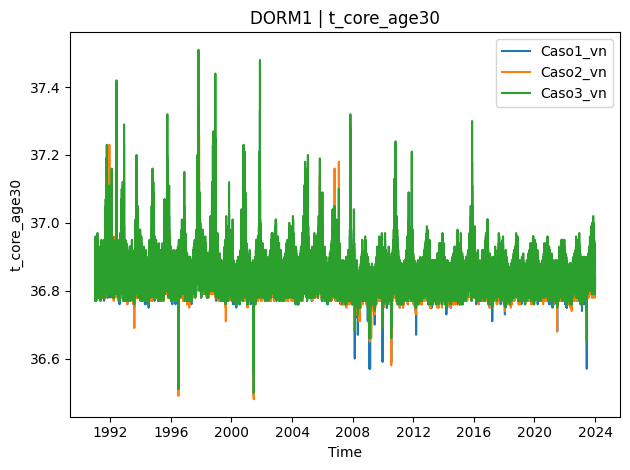

In [26]:
VAR = "t_core_age30"   

plt.figure()
for scenario, dfg in jos3_all.groupby("scenario"):
    plt.plot(dfg["timeset"], dfg[VAR], label=scenario)

plt.title(f"{ZONE} | {VAR}")
plt.xlabel("Time")
plt.ylabel(VAR)
plt.legend()
plt.tight_layout()
plt.show()

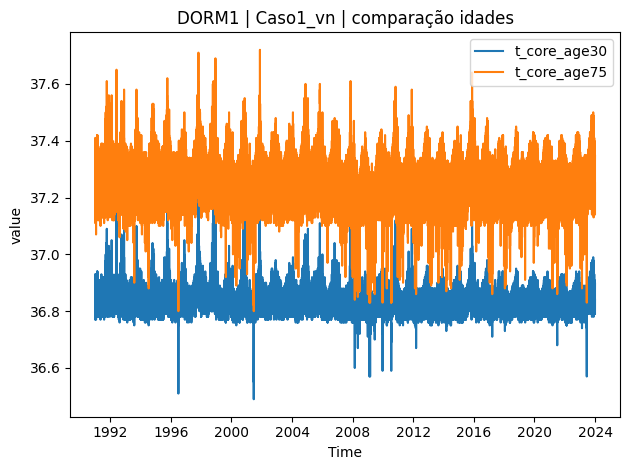

In [27]:
scenario = jos3_all["scenario"].unique()[0]  
dfg = jos3_all[jos3_all["scenario"] == scenario].copy()

VAR30 = "t_core_age30"
VAR75 = "t_core_age75"

plt.figure()
plt.plot(dfg["timeset"], dfg[VAR30], label=VAR30)
plt.plot(dfg["timeset"], dfg[VAR75], label=VAR75)
plt.title(f"{ZONE} | {scenario} | comparação idades")
plt.xlabel("Time")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Matheus\AppData\Local\Temp\ipykernel_11976\478413147.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


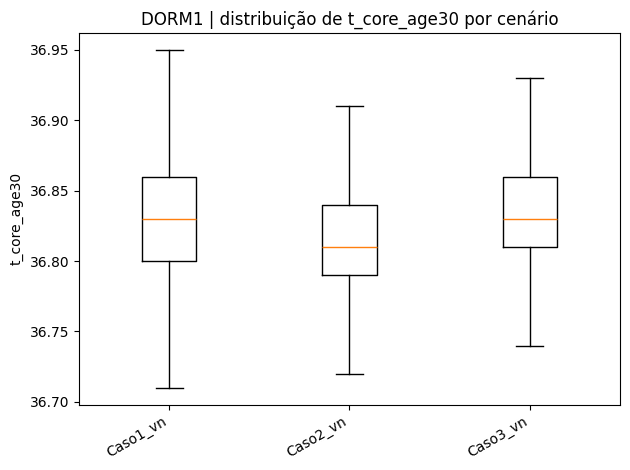

In [28]:
VAR = "t_core_age30"  # ajuste

data = []
labels = []
for scenario, dfg in jos3_all.groupby("scenario"):
    data.append(dfg[VAR].dropna().values)
    labels.append(scenario)

plt.figure()
plt.boxplot(data, labels=labels, showfliers=False)
plt.title(f"{ZONE} | distribuição de {VAR} por cenário")
plt.ylabel(VAR)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [29]:
print(jos3_all[["t_core_age30","t_skin_mean_age30","w_mean_age30"]].describe())

        t_core_age30  t_skin_mean_age30   w_mean_age30
count  867240.000000      867240.000000  867240.000000
mean       36.829281          35.458767       0.353631
std         0.038342           0.204903       0.140948
min        36.480000          33.810000       0.060000
25%        36.800000          35.300000       0.250000
50%        36.820000          35.460000       0.340000
75%        36.850000          35.610000       0.440000
max        37.510000          37.040000       1.000000


In [30]:
print(jos3_all[["t_core_age75","t_skin_mean_age75","w_mean_age75"]].describe())

        t_core_age75  t_skin_mean_age75   w_mean_age75
count  867240.000000      867240.000000  867240.000000
mean       37.228284          35.542944       0.279607
std         0.078004           0.262516       0.128232
min        36.800000          33.290000       0.060000
25%        37.170000          35.350000       0.180000
50%        37.220000          35.540000       0.260000
75%        37.280000          35.740000       0.360000
max        37.840000          36.920000       1.000000


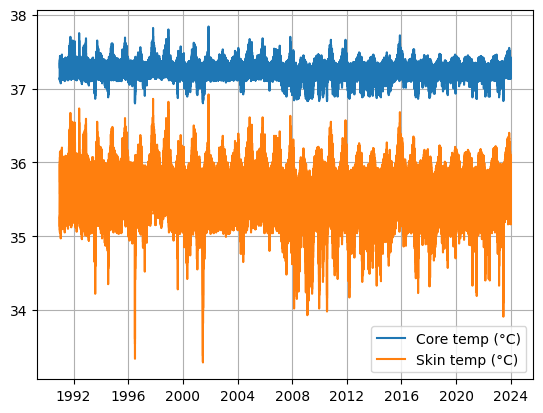

In [31]:
import matplotlib.pyplot as plt
plt.plot(jos3_all["timeset"], jos3_all["t_core_age75"], label="Core temp (°C)")
plt.plot(jos3_all["timeset"], jos3_all["t_skin_mean_age75"], label="Skin temp (°C)")
plt.legend(); plt.grid(); plt.show()